## Important Observations

(1) **In the dataset is a nearly-identical house to the target.

** You can assume that a next-door neighbor may predict a price best. (Is there evidence for this in the dataset?) 

If so use nearest-neighbor approach, first choosing the nearest home as a base price, then adjusting the price for the (only) three different features via the linear regression betas. The nearly-identical house also lets us fill in missing data points for our target.
    
(2) **Almost 100% of zeros and NaNs are Condos. Also, Condos have different Price distribution.

** The NaNs are in the Bath and HouseSizeSqft, which are the most important fields to assess our nearly-identical house. Discard all Condos. Then, only a few zeros/NaNs remain, which are replaced by the means since there are so few data points remaining.
    
(3) **Errors in Price (and most features) are not normally distributed.** Take log(Price) since it's much more normally distributed, and improved R^2. Error in features not being normal implies that the assumptions of linear regression may not be met. So, this data may not be ideal for linear regression.

(4) **Outliers.** The data contains outliers. Outliers can affect linear regression models, so you might want to remove them.

(5) **Lack of data.** After removing the Condos, only ~64 datapoints remain. This is insufficient for an accurate model. In fact, in looking at the regression analysis below, none of the p-values are significant (except for the Intercept), indicating either our data is bad or we need more of it.


## Results

(1) **Nearest Neighbor as the base price.** One of the homes is almost identical since it is a next-door neighbor. Only three of the features in the unknown house differ, the most significant being the HouseSizeSqft. So, using the betas from the Linear Regression, we can directly use the betas of these three to adjust the price of the next-door home.

    PREDICTED NEW PRICE:  $572,816.08

(2) **Linear Regression.**
    
    PREDICTED NEW PRICE:  $645,892.28.   (R^2: 0.40, R^2_adj: 0.34)
note: R-squared is a statistical measure of how close the data are to the fitted regression line.

For more evidence that its accuracy is correct, we'll predict the price of the home next door using our model. It seems pretty accurate:

    PREDICTED PRICE OF NEAREST NEIGHBOR:  $363,078.70
    --- ACTUAL PRICE OF NEAREST NEIGHBOR:  $322,000.0

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import statsmodels.formula.api as smf   # for "formula notation"

%matplotlib inline

In [38]:
# Load data
houses_raw = pd.read_csv("datasets/hw2-chicago.csv")
houses_raw.head()

,Address,Neighborhood,HouseType,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex
0,"2111 W Division St #5, Chicago IL",Wicker Park,Condo,390000,NaN,2.59,9,3.91,0,0,0,36.2
1,"1520 W Walton St #2, Chicago IL",Wicker Park,Condo,320500,NaN,4.10,7,3.02,0,0,0,91.7
2,"2047 W Thomas St, Chicago IL",Wicker Park,Multi-Family Home,620000,4,2.09,9,3.84,94,3049,3492,36.2
3,"1735 N Paulina St #314, Chicago IL",Wicker Park,Condo,318000,NaN,2.40,9,2.90,0,0,0,50.0
4,"1634 W Beach Ave, Chicago IL",Wicker Park,Multi-Family Home,477000,2,4.63,9,2.96,31,2614,1840,78.9


In [6]:
###########################
# DATA PRE-PROCESSING
###########################

# Two main steps -- 
# (1) Remove the 'Neighborhood' column, since all are Wicker Park.
# (2) HouseType and Address are non-numerical, so we'll either need to ignore the columns
#     or convert the data into something more meaningful

houses = houses_raw.copy()

if 'Neighborhood' in houses.columns:
    houses.drop('Neighborhood', axis=1, inplace=True)

# addresses: all of them have street name as the 3rd word. 
print(Counter([x.split()[2] for x in houses['Address']]))

# Note there are 5 houses on Leavitt, so might be worth it to index street names
# There are 40 unique street names -- index into a single column then visualize it
streets = list(set(x.split()[2] for x in houses_raw['Address']))
houses['Address'] = houses_raw['Address'].apply(lambda a: streets.index(a.split()[2]))

Counter({'Wabansia': 19, 'Wolcott': 18, 'Wood': 14, 'Paulina': 12, 'Saint': 10, 'Marshfield': 9, 'Hermitage': 9, 'Division': 9, 'Thomas': 7, 'Milwaukee': 7, 'Pierce': 7, 'Honore': 7, 'Augusta': 6, 'Bell': 6, 'North': 6, 'Winchester': 6, 'Haddon': 6, 'Crystal': 5, 'Ashland': 5, 'Damen': 5, 'Leavitt': 5, 'Potomac': 4, 'Hoyne': 4, 'Le': 4, 'Elk': 3, 'Beach': 3, 'Wilmot': 3, 'Bosworth': 3, 'Willow': 2, 'Winnebago': 2, 'Concord': 2, 'Cortez': 2, 'Julian': 2, 'Walton': 1, 'Caton': 1, 'Marion': 1, 'Blackhawk': 1, 'Ellen': 1, 'Churchill': 1, 'Evergreen': 1})


Leavitt Index:  39
Full Addresses:                                 Address Neighborhood           HouseType  \
53       1507 N Leavitt St, Chicago IL  Wicker Park  Single-Family Home   
68    1431 N Leavitt St #1, Chicago IL  Wicker Park               Condo   
104  1056 N Leavitt St #2F, Chicago IL  Wicker Park               Condo   
117   1427 N Leavitt St #2, Chicago IL  Wicker Park               Condo   
200      1338 N Leavitt St, Chicago IL  Wicker Park  Single-Family Home   

      Price  Bath  CrimeIndex  MinutesToLoop  MilesToLake  Age  LotSizeSqft  \
53   245000     1        3.51             10         3.86  121         3485   
68   300000   NaN        4.26             11         3.90    0            0   
104  303000   NaN        2.46             10         4.12    0            0   
117  320000   NaN        4.26             11         3.90    0            0   
200  322000     1        3.76             10         3.97  126         3049   

     HouseSizeSqft  SchoolIndex  
53  

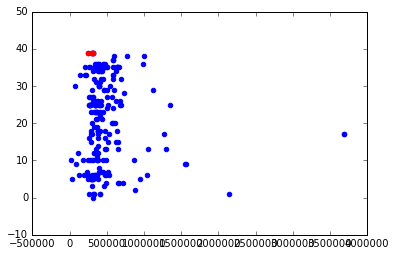

In [7]:
# This looks promising -- all houses on Leavitt have very similar prices.
# Let's see if we can predict this pricing range using the other data
leavitt = houses[houses['Address'] == streets.index('Leavitt')]

# Note that #200 is almost identical to the house we're looking for!
print('Leavitt Index: ', streets.index('Leavitt'))
print('Full Addresses: ', houses_raw.iloc[list(leavitt.index)])

# Prices on Leavitt are tightly clustered together -- three are condos so maybe not similar
plt.scatter(houses['Price'], houses['Address'], color='blue');
plt.scatter(leavitt['Price'], leavitt['Address'], color='red');

In [9]:
# There is a house very similar to our target.
NEAREST_INDEX = 200


# Generate the target
target_list = ['1342 N Leavitt St, Chicago IL', 'Wicker Park', 'Single-Family Home', 
               0, 2, 3.76, 0, 0, 116, 3049, 3154, 16.7]
target = pd.Series(data=target_list, index=houses_raw.columns)

# The main difference is the HouseSizeSqft (we're looking for 3154 sqft versus 1260 sqft). 
#   So, the strategy is to find the beta for HouseSizeSqft then hold everything else
#   constant and adjust. (Assuming it meets linear regression assumptions.)

# Linear relationship.
# Multivariate normality.
# No or little multicollinearity: two or more predictor variables in a multiple regression model are highly correlated
# No auto-correlation: similarity between observations as a function of the time lag between them
# Homoscedasticity: variance around the regression line is the same for all values of the predictor variable
pd.concat((houses_raw.iloc[NEAREST_INDEX], target), axis=1)    # view side-by-side


,200,0
Address,"1338 N Leavitt St, Chicago IL","1342 N Leavitt St, Chicago IL"
Neighborhood,Wicker Park,Wicker Park
HouseType,Single-Family Home,Single-Family Home
Price,322000,0
Bath,1,2
CrimeIndex,3.76,3.76
MinutesToLoop,10,0
MilesToLake,3.97,0
Age,126,116
LotSizeSqft,3049,3049


In [10]:
# Fill in unknowns, based on the house next door. SchoolIndex and CrimeIndex are the same. 
#   So, based on context, we likely know these values!
target['MinutesToLoop'] = 10
target['MilesToLake'] = 3.97

The strategy is to base the price of our target on the house next door.
Then, we'll adjust the price based on differences in three columns.

We have a few questions to answer/justify:
    
    (1) Is the price $322,000 an appropriate price for 1338 N Leavitt St?
    (2) How does price change with Bath 1 -> 2?
    (3) How does price change with HouseSizeSqft 1260 -> 3154?
    (4) How does price change with Age 126 -> 116?

For #1, we could use Nearest Neighbors, or analyze whether same-street is more accurate than, HouseSizeSqft. For #2-4, use Linear Regression, with some justification via NN.

In [11]:
# Let's look at the house prices for high sqft
#   prices are disparate (all much higher than our nearest neighbor)

houses[(houses['HouseSizeSqft'] > 2800) & (houses['HouseSizeSqft'] < 3400)]

,Address,HouseType,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex
37,36,Multi-Family Home,460000,4,5.65,9,3.06,121,3049,2856,33.3
57,38,Single-Family Home,770000,3,5.58,11,3.61,0,2614,2997,36.1
128,9,Single-Family Home,1570000,4,5.79,8,3.33,0,3049,3276,69.4
167,34,Multi-Family Home,625000,3,4.43,8,2.87,123,2614,3360,50.0
194,13,Single-Family Home,1300000,3,4.65,10,3.35,0,3049,3043,36.1


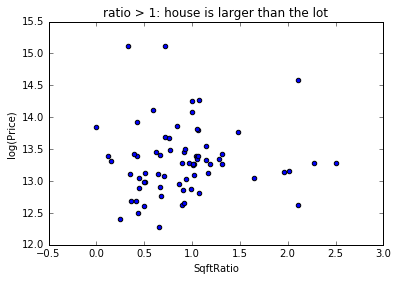

In [12]:
# Notice that the houseSqft > lotSqft in the target. Don't want to use both of these in
#   the model since they are correlated, but their ratio could be an indicator!

def getSqftRatio(row):
    if row['LotSizeSqft'] > 0:
        return row['HouseSizeSqft'] / row['LotSizeSqft']
    else:
        return np.NaN 

houses['SqftRatio'] = houses.apply(getSqftRatio, axis=1)

plt.scatter(houses['SqftRatio'], np.log(houses['Price']))    # Probably not a strong indicator
plt.title('ratio > 1: house is larger than the lot')
plt.xlabel('SqftRatio')
plt.ylabel('log(Price)')

In [13]:
# break the HouseType into separate columns
house_dict = {'Multi-Family Home': 'TypeMultiFamily', 'Townhome': 'TypeTownhome', 
              'Condo': 'TypeCondo', 'Lot/Land': 'TypeLotLand', 
              'Single-Family Home': 'TypeSingleFamily'}

house_types = list(set(houses_raw['HouseType']))
del house_types[house_types.index(np.NaN)]
print(house_types)

# Create a new column for each possible category
for house_type in house_types:
    houses[house_dict[house_type]] = houses_raw['HouseType'].apply(lambda x: 1 if x == house_type else 0)

# Drop the original column so that all columns are numeric
if 'HouseType' in houses.columns:
    houses.drop('HouseType', axis=1, inplace=True)
    
houses

['Condo', 'Multi-Family Home', 'Lot/Land', 'Townhome', 'Single-Family Home']


,Address,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex,SqftRatio,TypeCondo,TypeMultiFamily,TypeLotLand,TypeTownhome,TypeSingleFamily
0,18,390000,NaN,2.59,9,3.91,0,0,0,36.2,NaN,1,0,0,0,0
1,0,320500,NaN,4.10,7,3.02,0,0,0,91.7,NaN,1,0,0,0,0
2,26,620000,4,2.09,9,3.84,94,3049,3492,36.2,1.145294,0,1,0,0,0
3,10,318000,NaN,2.40,9,2.90,0,0,0,50.0,NaN,1,0,0,0,0
4,16,477000,2,4.63,9,2.96,31,2614,1840,78.9,0.703902,0,1,0,0,0
5,25,695000,2,1.40,8,2.86,23,2614,1628,50.0,0.622800,0,0,0,0,1
6,6,242500,NaN,5.38,9,3.22,0,0,0,69.4,NaN,1,0,0,0,0
7,6,477500,NaN,4.18,8,3.39,0,0,0,59.5,NaN,1,0,0,0,0
8,29,466000,2,4.93,10,4.02,121,3049,1344,16.7,0.440800,0,1,0,0,0
9,21,435000,2,4.75,8,2.89,119,3485,1760,40.0,0.505022,0,1,0,0,0


In [14]:
# Hypothesis: Zeros occur mainly with condos

type_cols = ['TypeCondo', 'TypeLotLand', 'TypeTownhome', 'TypeMultiFamily', 'TypeSingleFamily']

noage = houses[houses['Age'] == 0]
nosqft = houses[houses['HouseSizeSqft'] == 0]
nobath = houses[houses['Bath'].isnull()]

# Zeros: Age - 152, Lot - 149, House - 150, Bath - 149

print('ZEROS PER CATEGORY (age/house/bath)')
print('condo: ', sum(noage['TypeCondo']), sum(nosqft['TypeCondo']), sum(nobath['TypeCondo']))
print('lot/land: ', sum(noage['TypeLotLand']), sum(nosqft['TypeLotLand']), sum(nobath['TypeLotLand']))
print('single family: ', sum(noage['TypeSingleFamily']), sum(nosqft['TypeSingleFamily']), sum(nobath['TypeSingleFamily']))
print('multi family: ', sum(noage['TypeMultiFamily']), sum(nosqft['TypeMultiFamily']), sum(nobath['TypeMultiFamily']))
print('townhome: ', sum(noage['TypeTownhome']), sum(nosqft['TypeTownhome']), sum(nobath['TypeTownhome']))

ZEROS PER CATEGORY (age/house/bath)
condo:  133 146 146
lot/land:  1 1 1
single family:  8 1 0
multi family:  0 0 0
townhome:  9 0 0


In [15]:
# Let's look at the zeros and NaNs and try to understand them

print('Total houses:', len(houses))
print(houses.columns)
print('Number of zeros/col:', sum(houses.values == 0.0))   # Notice zeros in age (152), lotsizesqft (149), housesizesqft (150)

# Note if lotsize is 0, housesize is also zero except in one case where we have an additional housesize
print('LotSize and HouseSize both zero: ', sum((houses['LotSizeSqft'] == 0) & (houses['HouseSizeSqft'] == 0)))

# Note most of the time, age, lotsize, and housesize all missing (in 135 of 149 cases)
print('Age and LotSize both zero: ', sum((houses['Age'] == 0) & (houses['LotSizeSqft'] == 0)))

# Note HouseType and Address not included in describe(), so must also examine these
print('Invalid Address: ', sum((houses['Address'].isnull())))
print('Invalid Bath: ', sum((houses['Bath'].isnull())))

# Check rows where the type is missing
notype = houses[np.sum(houses[type_cols], axis=1) == 0]

print('\nNO HOUSE TYPE:')
print(notype)

# Min/max/mean/std look reasonable, except for the above three cols are >50% zeros
houses.describe()                  # Notice bath has only 70 non-NaN entires.

Total houses: 219
Index(['Address', 'Price', 'Bath', 'CrimeIndex', 'MinutesToLoop',
       'MilesToLake', 'Age', 'LotSizeSqft', 'HouseSizeSqft', 'SchoolIndex',
       'SqftRatio', 'TypeCondo', 'TypeMultiFamily', 'TypeLotLand',
       'TypeTownhome', 'TypeSingleFamily'],
      dtype='object')
Number of zeros/col: [  1   0   0   0   0   0 152 149 150   0   1  73 190 218 210 188]
LotSize and HouseSize both zero:  149
Age and LotSize both zero:  135
Invalid Address:  0
Invalid Bath:  149

NO HOUSE TYPE:
     Address   Price  Bath  CrimeIndex  MinutesToLoop  MilesToLake  Age  \
22        36  380000   NaN        5.68              9         3.37    0   
178       16  383000   NaN        4.63              9         2.94  119   
198       35  660000     3        5.65             10         3.29  118   

     LotSizeSqft  HouseSizeSqft  SchoolIndex  SqftRatio  TypeCondo  \
22             0              0         22.2        NaN          0   
178            0              0         78.9        Na

,Address,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex,SqftRatio,TypeCondo,TypeMultiFamily,TypeLotLand,TypeTownhome,TypeSingleFamily
count,219.000000,219.000000,70.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,70.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,20.707763,483431.050228,2.271429,4.663607,9.698630,3.420411,29.424658,873.200913,699.977169,49.197717,0.913980,0.666667,0.132420,0.004566,0.041096,0.141553
std,11.457400,400124.919077,0.883364,1.418146,2.898995,0.352522,49.155880,1392.893683,1175.278922,18.554525,0.507985,0.472484,0.339723,0.067574,0.198967,0.349389
min,0.000000,24500.000000,1.000000,1.090000,6.000000,2.770000,0.000000,0.000000,0.000000,16.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,319000.000000,2.000000,3.940000,8.000000,3.150000,0.000000,0.000000,0.000000,36.100000,0.531118,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.000000,390000.000000,2.000000,4.930000,9.000000,3.400000,0.000000,0.000000,0.000000,50.000000,0.912740,1.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,512500.000000,3.000000,5.580000,10.000000,3.685000,41.000000,2614.000000,1344.000000,59.500000,1.064078,1.000000,0.000000,0.000000,0.000000,0.000000
max,39.000000,3686000.000000,4.000000,8.080000,22.000000,4.200000,131.000000,7405.000000,6422.000000,93.900000,2.506315,1.000000,1.000000,1.000000,1.000000,1.000000


                   Address     Price      Bath  CrimeIndex  MinutesToLoop  \
Address           1.000000 -0.034597  0.006300   -0.059738      -0.229018   
Price            -0.034597  1.000000  0.113943    0.118667      -0.034644   
Bath              0.006300  0.113943  1.000000    0.163785       0.166330   
CrimeIndex       -0.059738  0.118667  0.163785    1.000000       0.194745   
MinutesToLoop    -0.229018 -0.034644  0.166330    0.194745       1.000000   
MilesToLake       0.070831 -0.072433 -0.157517    0.102382       0.374829   
Age               0.112824  0.237720 -0.039220   -0.036644      -0.023820   
LotSizeSqft       0.089687  0.443341 -0.029979   -0.008807      -0.053292   
HouseSizeSqft     0.087315  0.456272  0.698526    0.070952      -0.032437   
SchoolIndex      -0.118008 -0.072403 -0.047992   -0.100256      -0.196728   
SqftRatio        -0.054308 -0.015279  0.454919    0.331710       0.200184   
TypeCondo        -0.099424 -0.439396       NaN   -0.078911       0.056932   

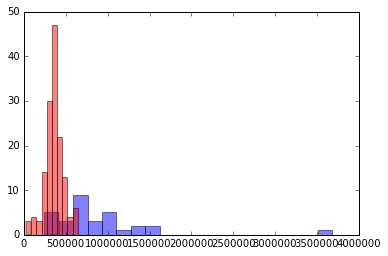

In [18]:
# additional evidence that condos may have different characteristics

# Note that Condo has -0.44 correlation coeff with Price, whereas SingleFamily has 0.40 coeff!
print(houses.corr())   

condos = houses[houses['TypeCondo'] == 1];
singles = houses[houses['TypeSingleFamily'] == 1];

# The price distributions look very different
plt.hist(singles['Price'].values, color='blue', alpha=0.5, bins=20);
plt.hist(condos['Price'].values, color='red', alpha=0.5, bins=10);

print('SINGLES: ', singles['Price'].describe())
print('\nCONDOS: ', condos['Price'].describe())

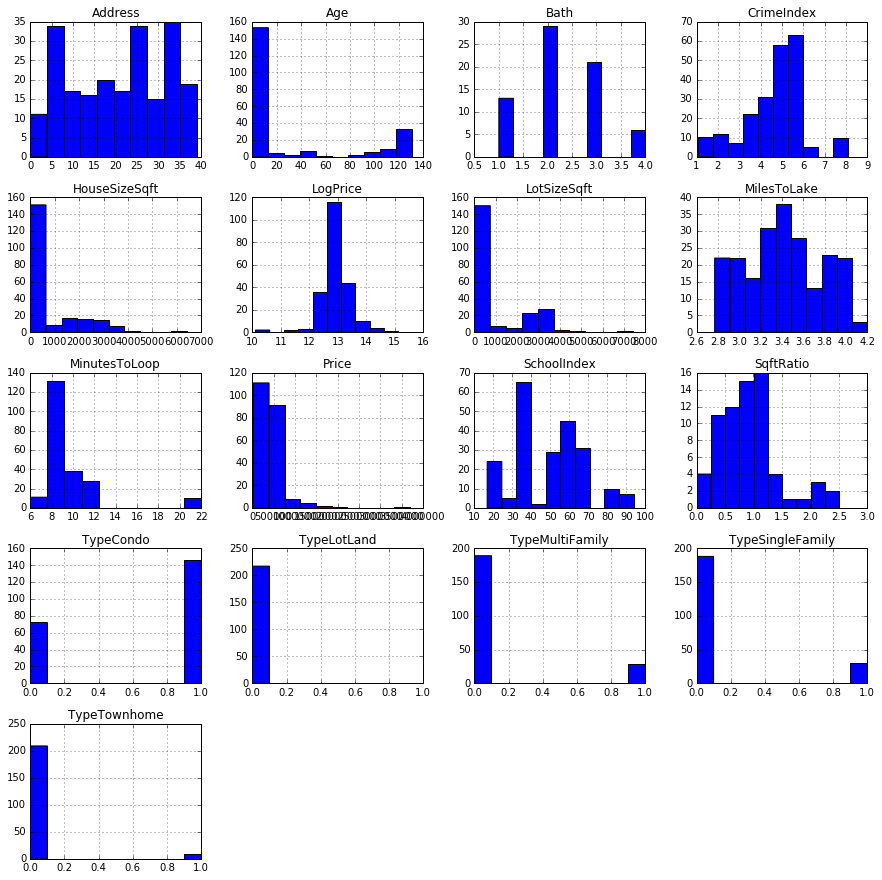

In [19]:
# Let's look at the histograms and see if we can log any of them to make it more normal
houses['LogPrice'] = houses['Price'].apply(np.log)     # this histogram looks normal

# Remove the price outlier seen earlier
houses.drop(singles[singles['Price'] > 2000000].index, inplace=True)

# Most do not look like errors are normal. So, next we will make some new log-columns
houses.hist(figsize=(15,15));

In [20]:
# At this point, we are trying to predict a single home house, finding
#   trends with the Bath and Sqft columns. So, condo prices don't matter -- and they
#   often have NaNs in the sqft/bath columns. Let's remove them, the three rows 
#   that have no type, and the lot/land rows.

hastype_rows = (np.sum(houses[type_cols], axis=1) > 0)

# Only save rows that are not condos, not lot/lands, and has at least one house type
houses_ols = houses[(houses['TypeCondo'] == 0) & (houses['TypeLotLand'] == 0) & hastype_rows].copy()

# Note we're down to 69 rows, which is not ideal
houses_ols

,Address,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex,SqftRatio,TypeCondo,TypeMultiFamily,TypeLotLand,TypeTownhome,TypeSingleFamily,LogPrice
2,26,620000,4,2.09,9,3.84,94,3049,3492,36.2,1.145294,0,1,0,0,0,13.337475
4,16,477000,2,4.63,9,2.96,31,2614,1840,78.9,0.703902,0,1,0,0,0,13.075272
5,25,695000,2,1.40,8,2.86,23,2614,1628,50.0,0.622800,0,0,0,0,1,13.451667
8,29,466000,2,4.93,10,4.02,121,3049,1344,16.7,0.440800,0,1,0,0,0,13.051941
9,21,435000,2,4.75,8,2.89,119,3485,1760,40.0,0.505022,0,1,0,0,0,12.983101
10,6,303000,2,4.68,8,3.43,119,3049,2728,59.5,0.894720,0,1,0,0,0,12.621488
11,34,314000,3,5.18,9,3.06,131,2614,2405,50.0,0.920046,0,1,0,0,0,12.657148
13,4,650000,3,3.89,10,3.86,119,3485,3618,16.7,1.038164,0,1,0,0,0,13.384728
14,6,490500,1,5.38,9,3.21,124,2614,922,69.4,0.352716,0,0,0,0,1,13.103181
16,33,590000,2,4.50,8,2.90,118,2614,2544,78.9,0.973221,0,1,0,0,0,13.287878


,Address,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex,SqftRatio,TypeCondo,TypeMultiFamily,TypeLotLand,TypeTownhome,TypeSingleFamily,LogPrice
Address,1.000000,-0.350749,-0.212278,-0.233031,-0.150212,0.267359,-0.057467,-0.169327,-0.158139,-0.297085,-0.036076,NaN,NaN,NaN,NaN,NaN,-0.388434
Price,-0.350749,1.000000,0.700155,0.339057,0.065231,-0.246115,-0.652077,0.018577,0.546067,-0.028670,0.450308,NaN,NaN,NaN,NaN,NaN,0.961208
Bath,-0.212278,0.700155,1.000000,0.443751,0.343348,-0.295068,-0.531221,-0.143366,0.708634,-0.110126,0.665581,NaN,NaN,NaN,NaN,NaN,0.689148
CrimeIndex,-0.233031,0.339057,0.443751,1.000000,0.173879,-0.094971,-0.110209,-0.210852,0.409593,0.005283,0.393218,NaN,NaN,NaN,NaN,NaN,0.298575
MinutesToLoop,-0.150212,0.065231,0.343348,0.173879,1.000000,0.315727,0.107671,0.098018,0.375346,-0.192711,0.342959,NaN,NaN,NaN,NaN,NaN,0.100072
MilesToLake,0.267359,-0.246115,-0.295068,-0.094971,0.315727,1.000000,0.258279,0.385729,-0.045594,-0.141409,-0.204351,NaN,NaN,NaN,NaN,NaN,-0.283259
Age,-0.057467,-0.652077,-0.531221,-0.110209,0.107671,0.258279,1.000000,-0.042527,-0.324176,-0.010169,-0.314421,NaN,NaN,NaN,NaN,NaN,-0.665434
LotSizeSqft,-0.169327,0.018577,-0.143366,-0.210852,0.098018,0.385729,-0.042527,1.000000,-0.111257,0.142259,-0.395815,NaN,NaN,NaN,NaN,NaN,0.027908
HouseSizeSqft,-0.158139,0.546067,0.708634,0.409593,0.375346,-0.045594,-0.324176,-0.111257,1.000000,-0.039687,0.905655,NaN,NaN,NaN,NaN,NaN,0.559851
SchoolIndex,-0.297085,-0.028670,-0.110126,0.005283,-0.192711,-0.141409,-0.010169,0.142259,-0.039687,1.000000,-0.056256,NaN,NaN,NaN,NaN,NaN,-0.085460


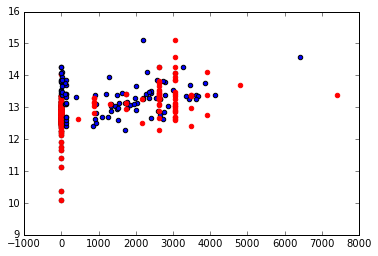

In [26]:
######################
# INVESTIGATE GRAPHS
######################

from pandas.tools.plotting import scatter_matrix
#scatter_matrix(houses, figsize=(15, 15));


# There is a huge spread of prices for LotSizeSqft for 3049 sqft 
#    ... so, can't use this to tell anything

plt.scatter(houses['HouseSizeSqft'], houses['LogPrice'])
plt.scatter(houses['LotSizeSqft'], houses['LogPrice'], color='red')


# Similary with baths -- a huge spread of prices, so not much can be said
#plt.scatter(houses['Bath'], houses['Price'])

houses_ols = houses_ols[houses_ols['TypeSingleFamily'] == 1].copy()

plt.scatter(houses_ols['Age'], houses_ols['LogPrice'])


houses_ols.corr()

In [27]:
# We still have a few NaNs/0s ... let's replace them all with the column means

# Replace zeros/NaNs with mean
replace_cols = {
        'LotSizeSqft': {0: houses_ols['LotSizeSqft'].mean()},
        'HouseSizeSqft': {0: houses_ols['HouseSizeSqft'].mean()},
        'Age': {0: houses_ols['Age'].mean()},
        'Bath': {np.NaN: houses_ols['Bath'].mean()}
    }

houses = houses.replace(to_replace = replace_cols)
houses_ols

,Address,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex,SqftRatio,TypeCondo,TypeMultiFamily,TypeLotLand,TypeTownhome,TypeSingleFamily,LogPrice
5,25,695000,2,1.40,8,2.86,23,2614,1628,50.0,0.622800,0,0,0,0,1,13.451667
14,6,490500,1,5.38,9,3.21,124,2614,922,69.4,0.352716,0,0,0,0,1,13.103181
19,2,885000,3,5.58,11,3.72,121,4792,3461,36.1,0.722245,0,0,0,0,1,13.693343
20,36,982500,3,4.65,9,2.98,0,2614,2783,33.3,1.064652,0,0,0,0,1,13.797856
31,13,1050000,2,5.65,9,3.41,131,3049,2580,69.4,0.846179,0,0,0,0,1,13.864301
32,29,1125000,2,4.93,10,4.03,21,3049,1290,16.7,0.423090,0,0,0,0,1,13.933294
38,25,675000,2,4.65,9,3.03,114,1742,2279,33.3,1.308266,0,0,0,0,1,13.422468
49,32,695000,3,4.93,9,3.29,0,2614,2403,59.5,0.919281,0,0,0,0,1,13.451667
52,26,326000,2,5.30,7,2.95,119,3049,1089,27.3,0.357166,0,0,0,0,1,12.694653
53,39,245000,1,3.51,10,3.86,121,3485,861,93.9,0.247059,0,0,0,0,1,12.409013


In [28]:
# Compare final correlations before we generate the OLS formula

houses_ols.corr()

,Address,Price,Bath,CrimeIndex,MinutesToLoop,MilesToLake,Age,LotSizeSqft,HouseSizeSqft,SchoolIndex,SqftRatio,TypeCondo,TypeMultiFamily,TypeLotLand,TypeTownhome,TypeSingleFamily,LogPrice
Address,1.000000,-0.350749,-0.212278,-0.233031,-0.150212,0.267359,-0.057467,-0.169327,-0.158139,-0.297085,-0.036076,NaN,NaN,NaN,NaN,NaN,-0.388434
Price,-0.350749,1.000000,0.700155,0.339057,0.065231,-0.246115,-0.652077,0.018577,0.546067,-0.028670,0.450308,NaN,NaN,NaN,NaN,NaN,0.961208
Bath,-0.212278,0.700155,1.000000,0.443751,0.343348,-0.295068,-0.531221,-0.143366,0.708634,-0.110126,0.665581,NaN,NaN,NaN,NaN,NaN,0.689148
CrimeIndex,-0.233031,0.339057,0.443751,1.000000,0.173879,-0.094971,-0.110209,-0.210852,0.409593,0.005283,0.393218,NaN,NaN,NaN,NaN,NaN,0.298575
MinutesToLoop,-0.150212,0.065231,0.343348,0.173879,1.000000,0.315727,0.107671,0.098018,0.375346,-0.192711,0.342959,NaN,NaN,NaN,NaN,NaN,0.100072
MilesToLake,0.267359,-0.246115,-0.295068,-0.094971,0.315727,1.000000,0.258279,0.385729,-0.045594,-0.141409,-0.204351,NaN,NaN,NaN,NaN,NaN,-0.283259
Age,-0.057467,-0.652077,-0.531221,-0.110209,0.107671,0.258279,1.000000,-0.042527,-0.324176,-0.010169,-0.314421,NaN,NaN,NaN,NaN,NaN,-0.665434
LotSizeSqft,-0.169327,0.018577,-0.143366,-0.210852,0.098018,0.385729,-0.042527,1.000000,-0.111257,0.142259,-0.395815,NaN,NaN,NaN,NaN,NaN,0.027908
HouseSizeSqft,-0.158139,0.546067,0.708634,0.409593,0.375346,-0.045594,-0.324176,-0.111257,1.000000,-0.039687,0.905655,NaN,NaN,NaN,NaN,NaN,0.559851
SchoolIndex,-0.297085,-0.028670,-0.110126,0.005283,-0.192711,-0.141409,-0.010169,0.142259,-0.039687,1.000000,-0.056256,NaN,NaN,NaN,NaN,NaN,-0.085460


In [33]:
# To test normalization, it does not make a difference in the R^2.
#    However, it would make a difference in interpreting/comparing the beta values
houses_ols_norm = (houses_ols - houses_ols.mean()) / (houses_ols.max() - houses_ols.min())
print("NORM")
print(houses_ols_norm)

# At least include house sqft, age, and bath since these are different from the other home

# P values evaluate how well the sample data support the devil’s advocate argument that the null hypothesis is true. 
    # It measures how compatible your data are with the null hypothesis. 
    # How likely is the effect observed in your sample data if the null hypothesis is true?
    # High P values: your data are likely with a true null.
    # Low P values: your data are unlikely with a true null.
    # A low P value suggests that your sample provides enough evidence that you can reject the null hypothesis for the entire population.

# The p-values are bad -- athough it has R^2 = 0.42, do not have enough data to
#   ensure these are statistically sound
# NOTE: Can test taking the log of each column by wrapping the column name in np.log()
ols = smf.ols(formula='LogPrice ~ HouseSizeSqft + Age + CrimeIndex + Bath + MilesToLake + SchoolIndex', data=houses_ols).fit()

print('PREDICTED PRICE: ', np.exp(ols.predict(target)))
print('PREDICTED PRICE OF NEAREST NEIGHBOR: ', np.exp(ols.predict(houses_ols.ix[NEAREST_INDEX])))
print('--- ACTUAL PRICE OF NEAREST NEIGHBOR: ', houses_ols.ix[NEAREST_INDEX]['Price'])

print('R^2: ', ols.rsquared)
print('R^2 Adjusted: ', ols.rsquared_adj)

ols.summary()


NORM
      Address     Price      Bath  CrimeIndex  MinutesToLoop  MilesToLake  \
5    0.117117 -0.067006 -0.011111   -0.723965      -0.126667    -0.485246   
14  -0.396396 -0.221346 -0.344444    0.143137      -0.060000    -0.198361   
19  -0.504505  0.076390  0.322222    0.186710       0.073333     0.219672   
20   0.414414  0.149975  0.322222   -0.015904      -0.060000    -0.386885   
31  -0.207207  0.200918 -0.011111    0.201961      -0.060000    -0.034426   
32   0.225225  0.257522 -0.011111    0.045098       0.006667     0.473770   
38   0.117117 -0.082101 -0.011111   -0.015904      -0.060000    -0.345902   
49   0.306306 -0.067006  0.322222    0.045098      -0.060000    -0.132787   
52   0.144144 -0.345497 -0.011111    0.125708      -0.193333    -0.411475   
53   0.495495 -0.406629 -0.344444   -0.264270       0.006667     0.334426   
57   0.468468 -0.010403  0.322222    0.186710       0.073333     0.129508   
59  -0.450450 -0.091912 -0.011111    0.045098      -0.060000    -0.1573

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               LogPrice   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     6.468
Date:                Fri, 18 Mar 2016   Prob (F-statistic):           0.000422
Time:                        09:11:21   Log-Likelihood:                -6.7904
No. Observations:                  30   AIC:                             27.58
Df Residuals:                      23   BIC:                             37.39
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        13.6571      0.827     16.512      0.000        11.946    15.368
HouseSizeSqft     0.0001      0.000      1.147      0.263     -9.25e-05     0.000
Age              -0.0038      0.001     -2.816      0.010        -0.007    -0.001
CrimeIndex        0.0199      0.070      0.286      0.777        -0.124     0.164
Bath              0.1323      0.118      1.124      0.273        -0.111     0.376
MilesToLake      -0.1317      0.200     -0.657      0.518        -0.546     0.283
SchoolIndex      -0.0018      0.003     -0.508      0.616        -0.009     0.005
==============================================================================
Omnibus:                        1.623   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.039
Skew:                          -0.068   Prob(JB):                        0.595
Kurtosis:                       2.099   Cond. No.                     2.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
#### DEFAULT RIDGE REGRESSION VIA SCIKIT-LEARN ####

from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

ridge_cols = ['Age', 'HouseSizeSqft', 'CrimeIndex', 'Bath', 'MilesToLake', 'SchoolIndex']

X = houses_ols[ridge_cols].values
y = houses_ols['LogPrice'].values

ridgelm = RidgeCV()
ridgelm.fit(X, y)

X_target = target[ridge_cols].values
X_nearest = houses_ols.ix[NEAREST_INDEX][ridge_cols].values

print(X_target)
print('PREDICTED PRICE: ', np.exp(ridgelm.predict(X_target)))
print('PREDICTED PRICE OF NEAREST NEIGHBOR: ', np.exp(ridgelm.predict(X_nearest)))
print('--- ACTUAL PRICE OF NEAREST NEIGHBOR: ', houses_ols.ix[NEAREST_INDEX]['Price'])

print('Default RidgeCV Score: ', ridgelm.score(X, y))

[116 3154 3.76 2 3.97 16.7]
PREDICTED PRICE:  [ 674422.82998958]
PREDICTED PRICE OF NEAREST NEIGHBOR:  [ 453938.84846957]
--- ACTUAL PRICE OF NEAREST NEIGHBOR:  322000.0
Default RidgeCV Score:  0.617228642532


In [20]:
# An alternative, depending on how much we trust the nearest house, would be
#    to adjust the nearest house price by the betas.

nearest = houses_ols.ix[NEAREST_INDEX]

print('OLS PARAMETERS:')
print(np.exp(ols.params))

# The logarithm of the price is computed, so we find the new Y as a proportion of the original Y.
#   (e^(beta_i) - 1) is the proportion change in Y per unit change x_i
price_adj = [pow(np.exp(ols.params[col]), (target[col] - nearest[col])) for col in ols.params.index if col != 'Intercept']

new_price = houses_ols.ix[NEAREST_INDEX]['Price']
new_price *= np.prod(price_adj)

print('\nPrice adjustments: ', price_adj)

print('\nPREDICTED NEW PRICE (combining nearest neighbor with lin reg betas): ', new_price)

OLS PARAMETERS:
Intercept        853476.760390
HouseSizeSqft         1.000115
Age                   0.996172
CrimeIndex            1.020102
Bath                  1.141479
MilesToLake           0.876594
SchoolIndex           0.998232
dtype: float64

Price adjustments:  [1.2439339672519081, 1.0390952454480968, 1.0, 1.1414791309394372, 1.0, 1.0]

PREDICTED NEW PRICE (combining nearest neighbor with lin reg betas):  475090.703418
